In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0,"../")

In [ ]:
from torch.utils.data import DataLoader
import torch

In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from core.model.model import MoCo_scene_and_view as MoCo
from core.dataloader import CLEVR_train, collate_boxes, CLEVR_train_onlyquery, collate_boxes_onlyquery
from core.utils import compute_features
from core.dataloader import sample_same_scene_negs
from vis_utils import *

In [ ]:
# # kmeans_train_dataset = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5v.txt')
# # kmeans_train_loader = DataLoader(kmeans_train_dataset, batch_size=16, shuffle=False, collate_fn=collate_boxes_onlyquery)

# query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, scenes=10)
# # query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

In [ ]:
from attrdict import AttrDict

args = AttrDict({
    'mode':"spatial",
    'hyp_N':2
})

In [ ]:
PATH = "../tb_logs/two_obj_spatial_with_scene_and_view_loss_exp39/checkpoint_299.pth.tar"
state_dict = torch.load(PATH)['state_dict']
view_r = state_dict["queue_view"].shape[1]
scene_r = state_dict["queue_scene"].shape[1]

model = MoCo(mode="spatial", scene_r=scene_r, view_r=view_r)
model = model.cuda()

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, scenes=10)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, str(k_idx) + " **" )
    store_to_pool_e(pool_g_, feed_dict_k_, metadata_, model, args, "!", "!")
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())

        
print(pool_e_.num)
print(pool_g_.num)

Initialised..... 10  files...
40
724


[2, 37, 38, 26, 33, 6, 29, 5, 25, 1]


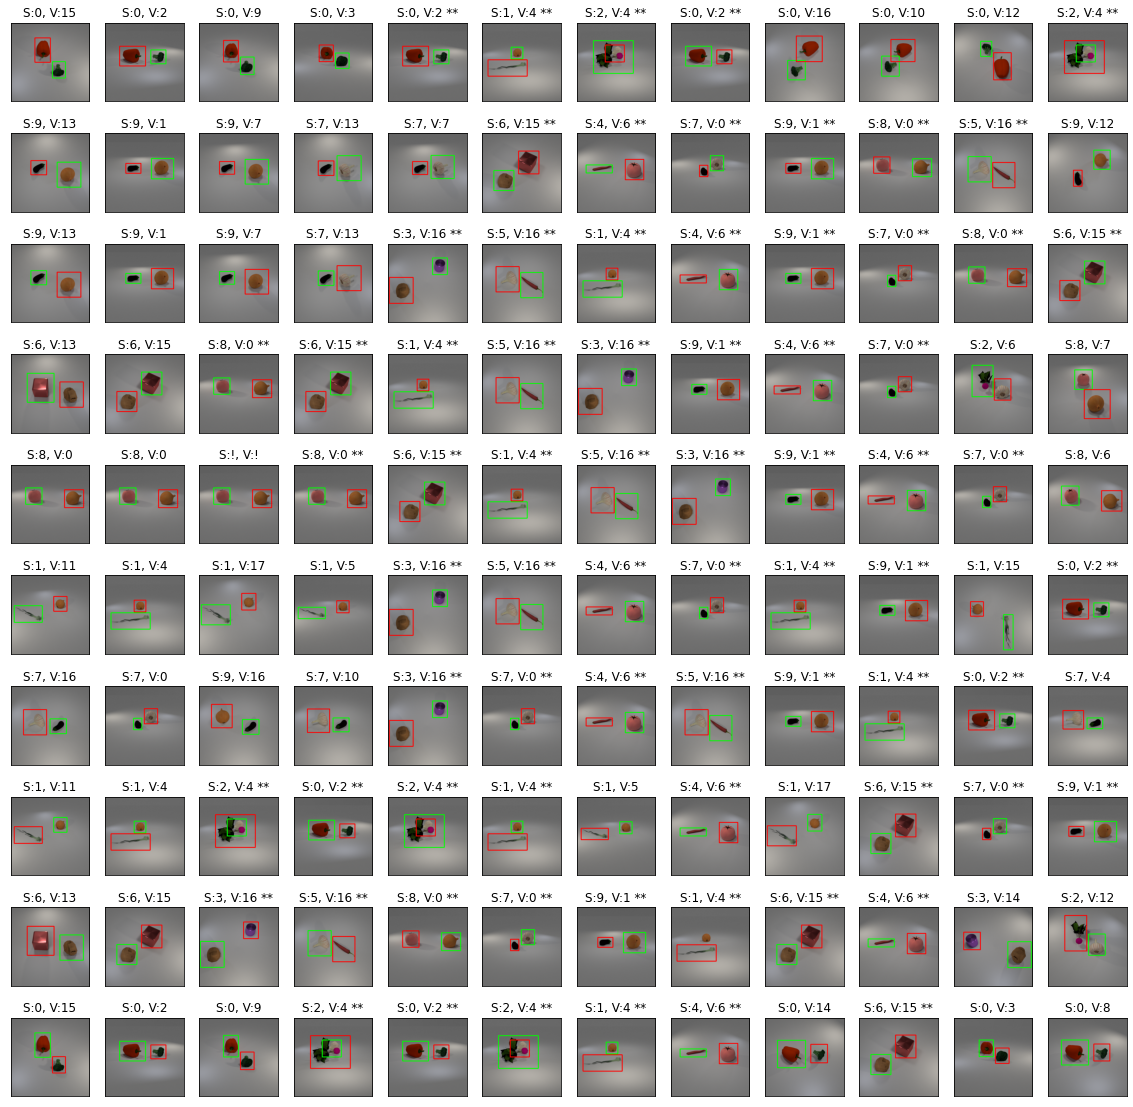

In [ ]:
f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=10)

In [ ]:
PATH = "../tb_logs/two_obj_spatial_with_scene_and_view_loss_exp40/checkpoint_299.pth.tar"
state_dict = torch.load(PATH)['state_dict']
view_r = state_dict["queue_view"].shape[1]
scene_r = state_dict["queue_scene"].shape[1]

model = MoCo(mode="spatial", scene_r=scene_r, view_r=view_r)
model = model.cuda()

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, scenes=10)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    store_to_pool_e(pool_g_, feed_dict_k_, metadata_, model, args, "!", "!")
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())

        
print(pool_e_.num)
print(pool_g_.num)

Initialised..... 10  files...
40
724


[5, 9, 21, 22, 10, 6, 38, 26, 2, 13]


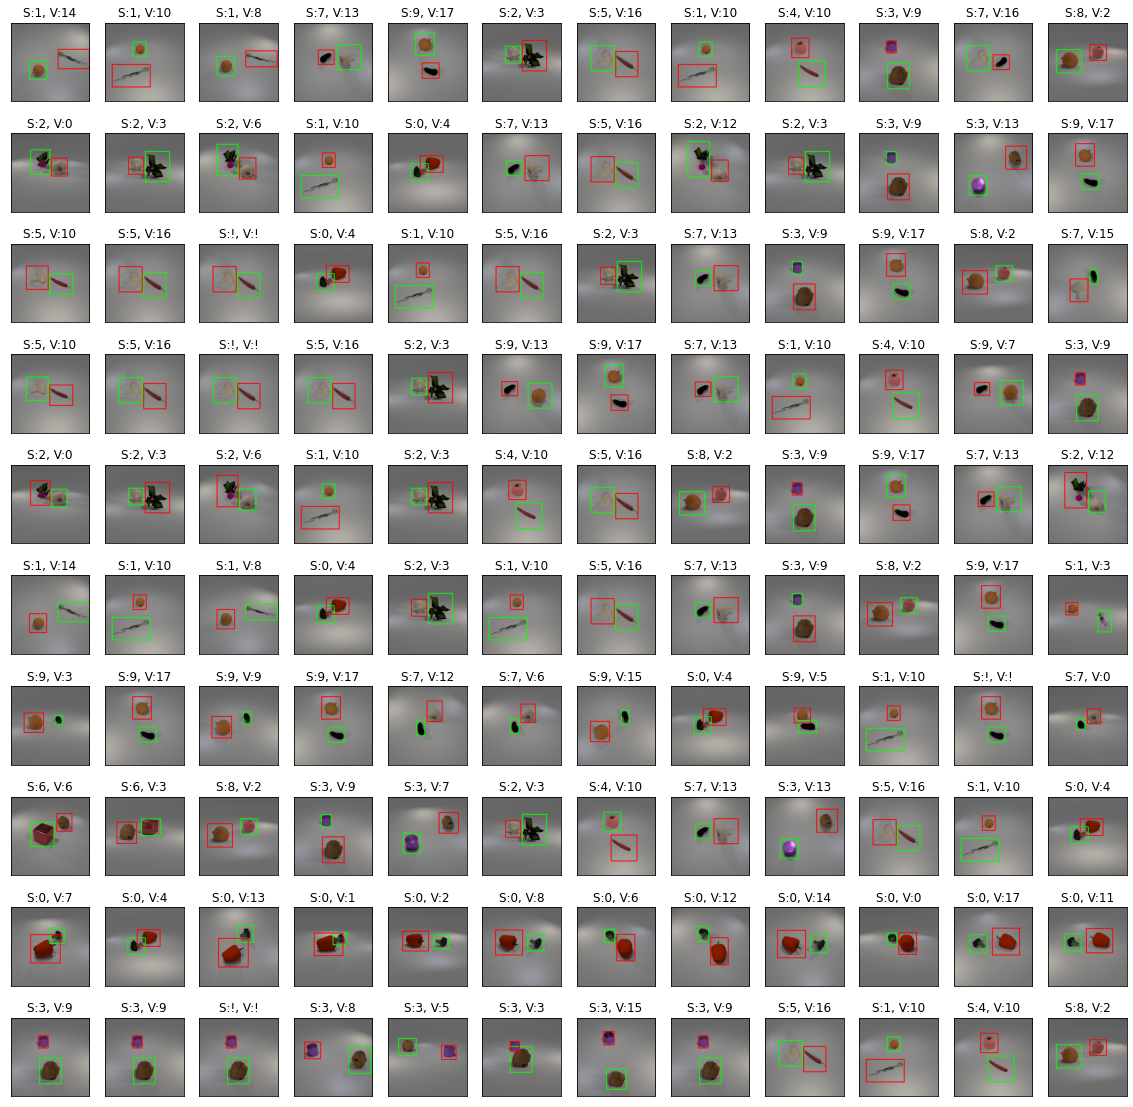

In [ ]:
f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=10)

In [ ]:
PATH = "../tb_logs/two_obj_spatial_with_scene_and_view_loss_exp40/checkpoint_299.pth.tar"
state_dict = torch.load(PATH)['state_dict']
view_r = state_dict["queue_view"].shape[1]
scene_r = state_dict["queue_scene"].shape[1]

model = MoCo(mode="spatial", scene_r=scene_r, view_r=view_r)
model = model.cuda()

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2, scenes=10)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, str(k_idx) + "**")
    store_to_pool_e(pool_g_, feed_dict_k_, metadata_, model, args, "!", "!")
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())

        
print(pool_e_.num)
print(pool_g_.num)

Initialised..... 10  files...
40
728


[13, 6, 1, 34, 29, 9, 25, 17, 37, 26]


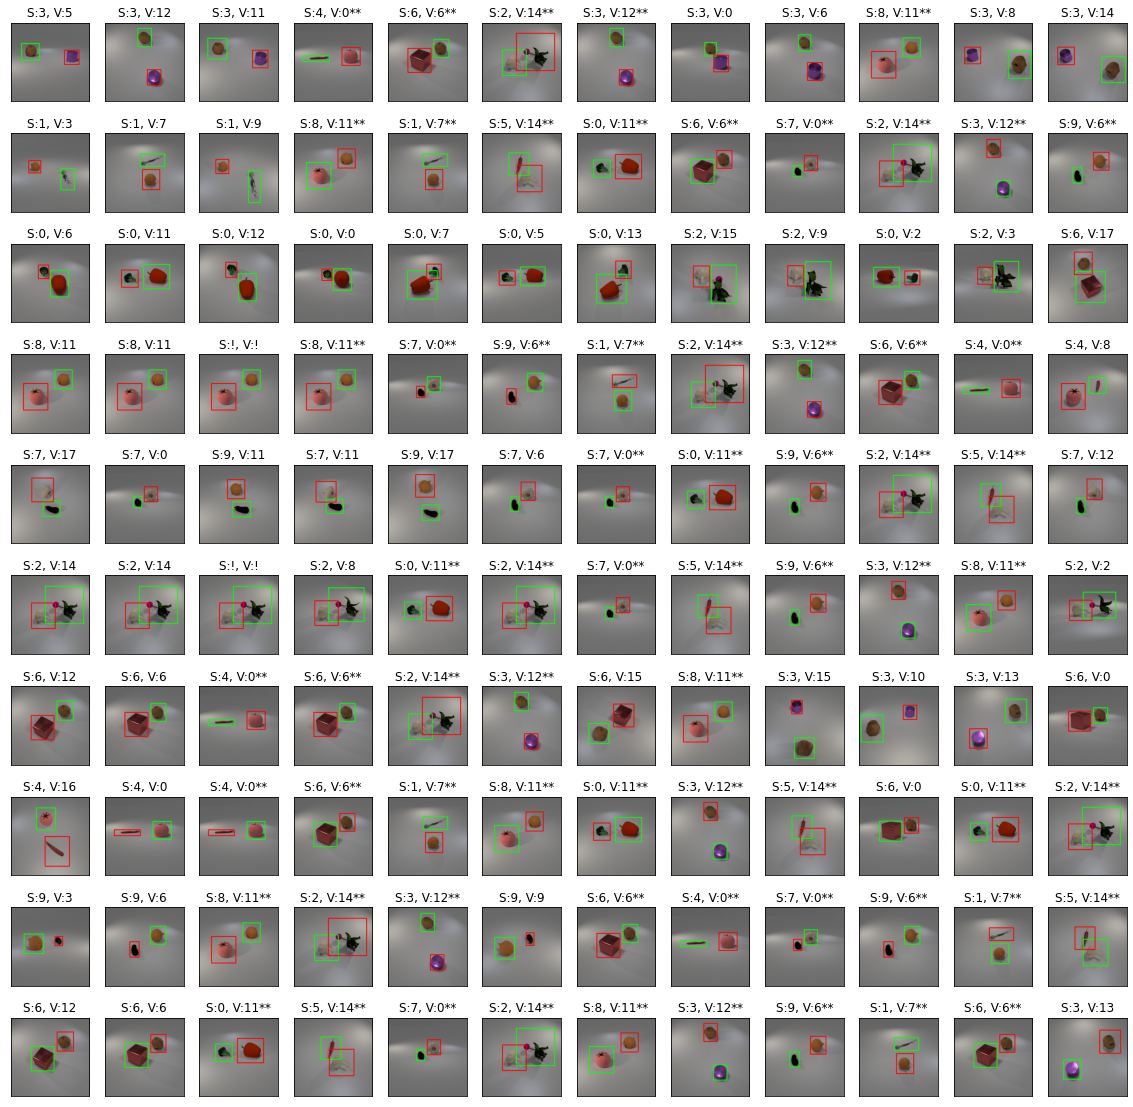

In [ ]:
f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=10)

In [ ]:
PATH = "../tb_logs/two_obj_spatial_with_scene_and_view_loss_exp36/checkpoint_399.pth.tar"
state_dict = torch.load(PATH)['state_dict']
view_r = state_dict["queue_view"].shape[1]
scene_r = state_dict["queue_scene"].shape[1]

model = MoCo(mode="spatial", scene_r=scene_r, view_r=view_r)
model = model.cuda()

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
pool_size = 80
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(5000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=True, collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, str(k_idx) + " ***")
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())
        
    if i>20:
        break

        
print(pool_e_.num)
print(pool_g_.num)

Initialised..... 234  files...
80
1508


[61, 65, 70, 58, 21, 46, 14, 34, 10, 17]


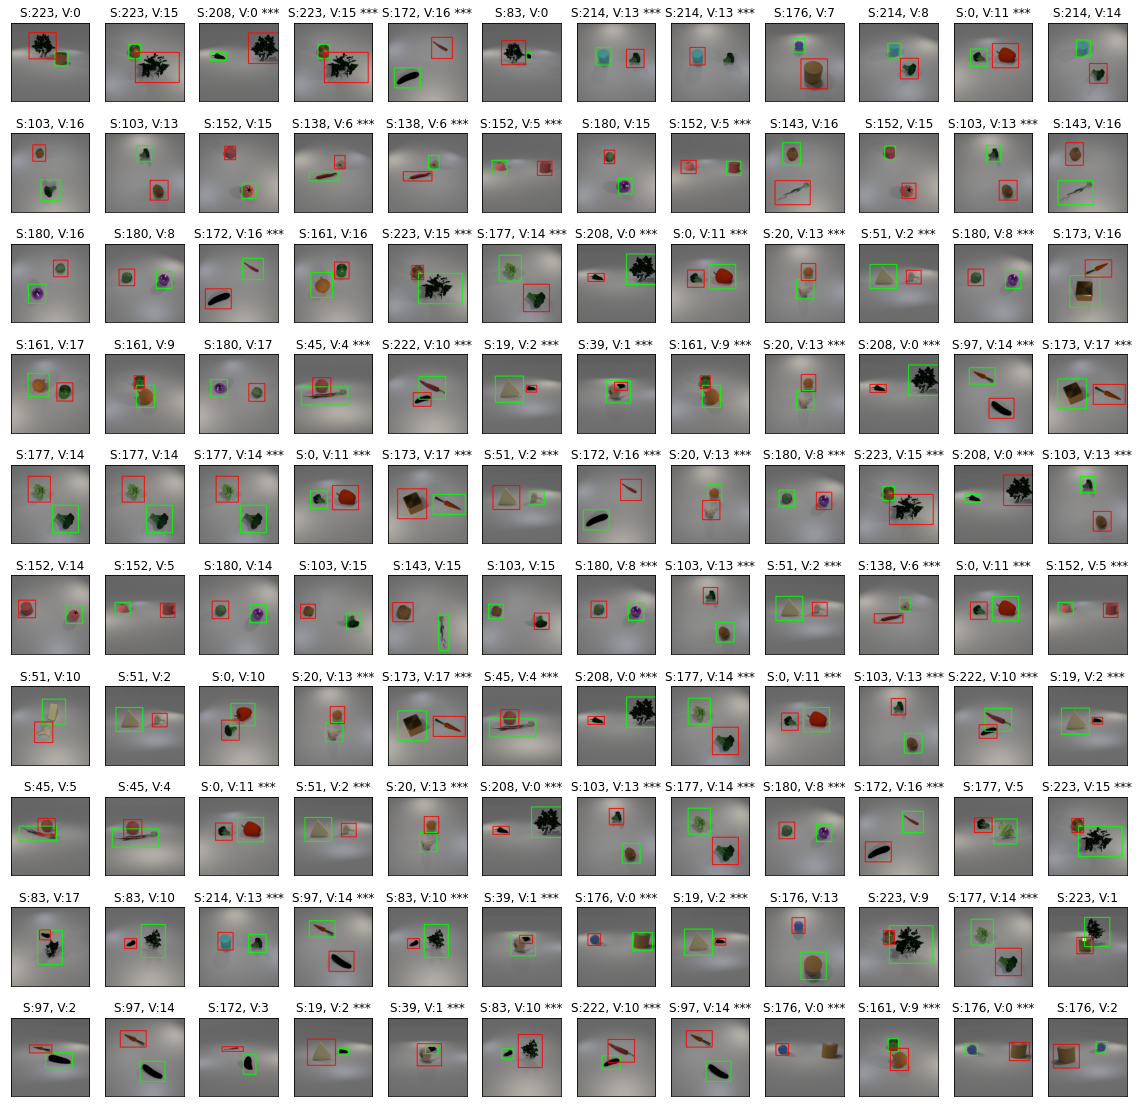

In [ ]:
f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=10)

In [ ]:
pool_size = 80
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(5000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5v.txt', hyp_N=2)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=True, collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, str(k_idx) + " **")
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())
        
    if i>20:
        break

        
print(pool_e_.num)
print(pool_g_.num)

Initialised..... 59  files...
80
1496


In [ ]:
f = random_retrieve_topk(args, pool_e_, pool_g_, pool_f_, imgs_to_view=10)

[33, 54, 9, 62, 17, 49, 34, 41, 6, 73]
